In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import pandas_datareader.data as web
import pickle 
import requests
import tensorflow as tf

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\f

In [2]:
name = 'Actor-critic Duel agent'
image_path = 'D:/kenneth/agent/images/'
ticker = '^GSPC'
start=('2019-01-01')
end=('2019-12-31')
# df=web.DataReader(ticker,'yahoo',start,end)
# df.to_csv(ticker+'.csv')
df = pd.read_csv('D:/kenneth/agent/'+ticker+'.csv', index_col=0, parse_dates=True)

#  Agents

* Turtle Trading agent
* Moving Average agent
* Signal Rolling agent
* Policy Gradient agent
* Q-learning agent
* Evolution Strategy agent
* Double Q-learning agent
* Recurrent Q-learning agent
* Double Recurrent Q-learning agent
* Duel Q-learning agent
* Double Duel Q-learning agent
* Duel Recurrent Q-learning agent
* Double Duel Recurrent Q-learning agent
* Actor-critic agent
* Actor-critic Duel agent
* Actor-critic Recurrent agent
* Actor-critic Duel Recurrent agent
* Curiosity Q-learning agent
* Recurrent Curiosity Q-learning agent
* Duel Curiosity Q-learning agent
* Neuro-evolution agent
* Neuro-evolution with Novelty search agent
* ABCD strategy agent
* Deep Evolution Strategy

## Actor-critic Duel agent

In [3]:
from collections import deque
import random

name = 'Actor-critic Duel agent'

class Actor:
    def __init__(self, name, input_size, output_size, size_layer):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            feed_actor = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            tensor_action, tensor_validation = tf.split(feed_actor,2,1)
            feed_action = tf.layers.dense(tensor_action, output_size)
            feed_validation = tf.layers.dense(tensor_validation, 1)
            self.logits = feed_validation + tf.subtract(feed_action,
                                                        tf.reduce_mean(feed_action,axis=1,keep_dims=True))

class Critic:
    def __init__(self, name, input_size, output_size, size_layer, learning_rate):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            self.REWARD = tf.placeholder(tf.float32, (None, 1))
            feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            tensor_action, tensor_validation = tf.split(feed_critic,2,1)
            feed_action = tf.layers.dense(tensor_action, output_size)
            feed_validation = tf.layers.dense(tensor_validation, 1)
            feed_critic = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            feed_critic = tf.nn.relu(feed_critic) + self.Y
            feed_critic = tf.layers.dense(feed_critic, size_layer//2, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_critic, 1)
            self.cost = tf.reduce_mean(tf.square(self.REWARD - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
            
class Agent:

    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.actor = Actor('actor-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.actor_target = Actor('actor-target', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.critic = Critic('critic-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.critic_target = Critic('critic-target', self.state_size, self.OUTPUT_SIZE, 
                                    self.LAYER_SIZE, self.LEARNING_RATE)
        self.grad_critic = tf.gradients(self.critic.logits, self.critic.Y)
        self.actor_critic_grad = tf.placeholder(tf.float32, [None, self.OUTPUT_SIZE])
        weights_actor = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.grad_actor = tf.gradients(self.actor.logits, weights_actor, -self.actor_critic_grad)
        grads = zip(self.grad_actor, weights_actor)
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)
            
    def _memorize(self, state, action, reward, new_state, dead):
        self.MEMORIES.append((state, action, reward, new_state, dead))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            prediction = self.sess.run(self.actor.logits, feed_dict={self.actor.X:[state]})[0]
            action = np.argmax(prediction)
        return action
    
    def _construct_memories_and_train(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.sess.run(self.actor.logits, feed_dict={self.actor.X: states})
        Q_target = self.sess.run(self.actor_target.logits, feed_dict={self.actor_target.X: states})
        grads = self.sess.run(self.grad_critic, feed_dict={self.critic.X:states, self.critic.Y:Q})[0]
        self.sess.run(self.optimizer, feed_dict={self.actor.X:states, self.actor_critic_grad:grads})
        
        rewards = np.array([a[2] for a in replay]).reshape((-1, 1))
        rewards_target = self.sess.run(self.critic_target.logits, 
                                       feed_dict={self.critic_target.X:new_states,self.critic_target.Y:Q_target})
        for i in range(len(replay)):
            if not replay[0][-1]:
                rewards[i] += self.GAMMA * rewards_target[i]
        cost, _ = self.sess.run([self.critic.cost, self.critic.optimizer], 
                                feed_dict={self.critic.X:states, self.critic.Y:Q, self.critic.REWARD:rewards})
        return cost
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('actor-original', 'actor-target')
                    self._assign('critic-original', 'critic-target')
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories_and_train(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 20, checkpoint = 1, initial_money = initial_money)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch: 1, total rewards: 989.950684.3, cost: 1.082233, total money: 5002.310791
epoch: 2, total rewards: 559.980713.3, cost: 3.004758, total money: 4595.880859
epoch: 3, total rewards: 752.479492.3, cost: 1.482698, total money: 10752.479492
epoch: 4, total rewards: 515.830566.3, cost: 3.592444, total money: 7517.880615
epoch: 5, total rewards: 277.678467.3, cost: 5.621395, total money: 10277.678467
epoch: 6, total rewards: 210.739990.3, cost: 5.870885, total money: 10210.739990
epoch: 7, total rewards: 527.719971.3, cost: 20.721016, total money: 4534.090088
epoch: 8, total rewards: 919.539062.3, cost: 21.947584, total money: 4925.909180
epoch: 9, total rewards: -69.061279.3, cost: 25.890362, total money: 3943.298828
epoch: 10, total rewards: 826.319580.3, cost: 486.388397, total money: 2021.349609
epoch: 11, total rewards: 121.829834.3, cost: 8380.998047, total money: 4264.300049
epoch: 12, total rewards: 1014.329

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 2510.030029, total balance 7489.969971
day 1, sell 1 unit at price 2447.889893, investment -2.475673 %, total balance 9937.859863,
day 2: buy 1 unit at price 2531.939941, total balance 7405.919922
day 3, sell 1 unit at price 2549.689941, investment 0.701043 %, total balance 9955.609863,
day 4: buy 1 unit at price 2574.409912, total balance 7381.199951
day 5: buy 1 unit at price 2584.959961, total balance 4796.239990
day 7, sell 1 unit at price 2596.260010, investment 0.848742 %, total balance 7392.500000,
day 10: buy 1 unit at price 2616.100098, total balance 4776.399902
day 12: buy 1 unit at price 2670.709961, total balance 2105.689941
day 13, sell 1 unit at price 2632.899902, investment 1.854572 %, total balance 4738.589844,
day 14, sell 1 unit at price 2638.699951, investment 0.863876 %, total balance 7377.289795,
day 16, sell 1 unit at price 2664.760010, investment -0.222785 %, total balance 10042.049805,
day 19: buy 1 unit at price 2681.050049, total bal

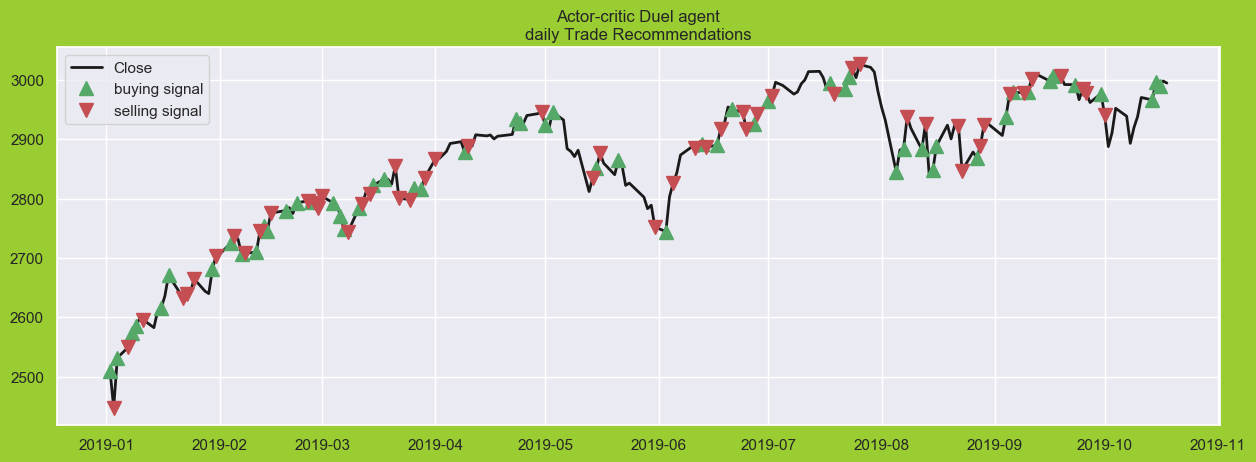

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=2., alpha=0.5)
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title(name+'\n'+'daily Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()

In [7]:
display_days = 30
total_days= df.shape[0]
display_from = total_days-display_days

In [8]:
new_buy = []
for i in(states_buy):
    if i > display_from:
        adj = i- display_from
        new_buy.append(adj)
new_buy

[1, 5, 6, 10, 15, 25, 26, 27]

In [9]:
new_sell = []
for i in(states_sell):
    if i > display_from:
        adj = i- display_from
        new_sell.append(adj)
new_sell

[2, 8, 12, 13, 16]

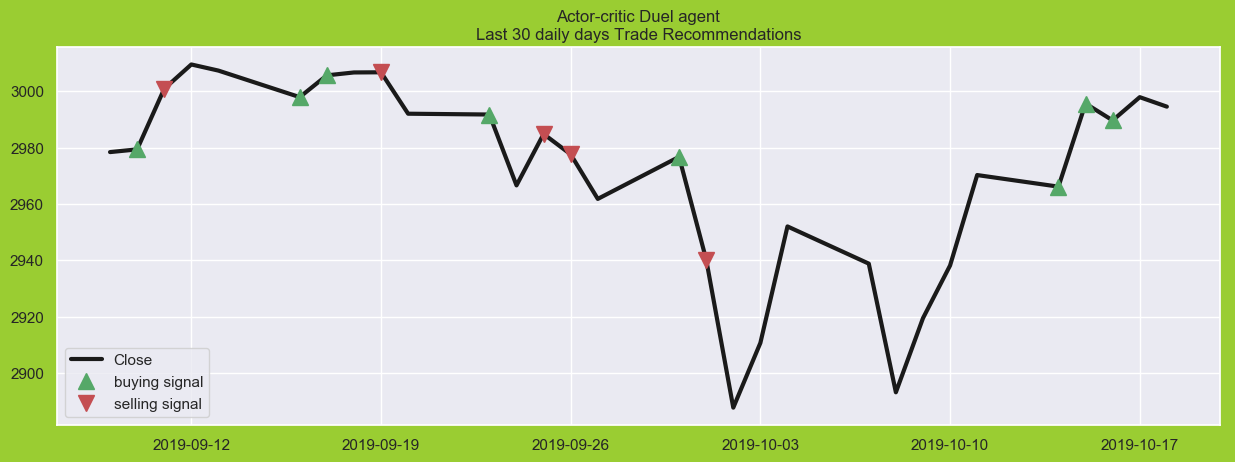

In [10]:
close = df['Close'][-display_days:]
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=3., alpha=0.5)
plt.plot(close, '^', markersize=12, color='g',alpha=1.0,label = 'buying signal', markevery = new_buy)
plt.plot(close, 'v', markersize=12, color='r',alpha=1.0, label = 'selling signal', markevery = new_sell)
plt.title(name+'\n'+'Last '+str(display_days)+' daily days Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
#plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()